# GDAX
Buy Orders - order minimums are enforced on the quote currency. For example, the ETH-USD book has a minimum size of 10 USD. 

Sell Orders - order minimums are enforced in the base currency. For example, the BTC-USD book has a minimum size of 0.001 BTC.

https://support.gdax.com/customer/portal/articles/2725970-trading-rules

# CEX.IO

https://cex.io/api/currency_limits
 

In [140]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [152]:
cex_min_sizes = requests.get('https://cex.io/api/currency_limits').json()['data']['pairs']
#print('cex_min_sizes: {}'.format(cex_min_sizes[:2]))

In [153]:
gdax_min_sizes = requests.get('https://api.gdax.com/products').json()
#gdax_currencies = requests.get('https://api.gdax.com/currencies').json()
#print('gdax_min_sizes: {}'.format(gdax_min_sizes[2]))
#print('gdax_currencies: {}'.format(gdax_currencies[2]))

In [154]:
rates = requests.get('https://cex.io/api/last_prices/BTC/ETH/BCH/EUR').json()
rates_eur = {'EUR': 1.0}
for rate in rates['data']:
    if rate['symbol2'] == 'EUR':
        rates_eur[rate['symbol1']] = float(rate['lprice'])
    if rate['symbol1'] == 'EUR':
        rates_eur[rate['symbol2']] = 1.0/float(rate['lprice'])

print('rates_eur: {}'.format(rates_eur))

rates_eur: {'EUR': 1.0, 'BTC': 5780.1, 'ETH': 461.6, 'BCH': 800.0, 'BTG': 28.79, 'DASH': 234.0, 'XRP': 0.4732, 'XLM': 0.2046, 'ZEC': 169.49}


In [155]:
pairs = [
    ['EUR', 'BTC'],
    ['EUR', 'BCH'],
    ['EUR', 'ETH'],
    ['BTC', 'ETH'],
    ['BTC', 'BCH']
]

#gdax_min_sizes = {
#    'BTC': 0.001, 
#    'BCH': 0.01, 
#    'ETH': 0.01, 
#    'LTC': 0.1, 
#    'USD': 10,
#    'EUR': 10,
#    'GBP': 10,
#}


def get_min_in_from_cex(currency_from, currency_to):
    for pair in cex_min_sizes:
        if pair['symbol1'] == currency_from and pair['symbol2'] == currency_to:
            return pair['minLotSize']
        elif pair['symbol1'] == currency_to and pair['symbol2'] == currency_from:
            return pair['minLotSizeS2']
        
    raise Exception('cannot determine min amount for {}->{}'.format(currency_from, currency_to))
    
def get_min_in_from_gdax(currency_from, currency_to):
    for pair in gdax_min_sizes:
        if pair['base_currency'] == currency_from and pair['quote_currency'] == currency_to:
            return pair['base_min_size']
        elif pair['base_currency'] == currency_to and pair['quote_currency'] == currency_from:
            return pair['min_market_funds']
    raise Exception('cannot determine min amount for {}->{}'.format(currency_from, currency_to))

In [156]:
df = pd.DataFrame([], columns=['from_to', 'from', 'to', 'gdax', 'cex'])
for p in pairs:
    df = df.append([
        {'from': p[0], 'to': p[1], 'gdax': get_min_in_from_gdax(p[0], p[1]), 'cex': get_min_in_from_cex(p[0], p[1])}, 
        {'from': p[1], 'to': p[0], 'gdax': get_min_in_from_gdax(p[1], p[0]), 'cex': get_min_in_from_cex(p[1], p[0])}
    ], ignore_index=True)
df['from_to'] = df['from'] + '->' + df['to']
df['gdax'] = pd.to_numeric(df['gdax'])
df['cex'] = pd.to_numeric(df['cex'])

df['gdax_eur'] = df.apply (lambda row: rates_eur[row['from']] * row['gdax'], axis=1)
df['cex_eur'] = df.apply (lambda row: rates_eur[row['from']] * row['cex'], axis=1)

print(df)
#print(df.info())

#df2 = pd.melt(df, id_vars=['from_to', 'from', 'to'], value_vars=['gdax', 'cex'], var_name='marketplace', value_name='min_from')
#df2 = df2.pivot(index=['from_to', 'from', 'to'], columns='marketplace', values='min_from')
#print(df2)


    from_to from   to    gdax     cex  gdax_eur  cex_eur
0  EUR->BTC  EUR  BTC  10.000  20.000   10.0000  20.0000
1  BTC->EUR  BTC  EUR   0.001   0.002    5.7801  11.5602
2  EUR->BCH  EUR  BCH  10.000  20.000   10.0000  20.0000
3  BCH->EUR  BCH  EUR   0.010   0.020    8.0000  16.0000
4  EUR->ETH  EUR  ETH  10.000  20.000   10.0000  20.0000
5  ETH->EUR  ETH  EUR   0.010   0.050    4.6160  23.0800
6  BTC->ETH  BTC  ETH   0.001   0.001    5.7801   5.7801
7  ETH->BTC  ETH  BTC   0.010   0.025    4.6160  11.5400
8  BTC->BCH  BTC  BCH   0.001   0.001    5.7801   5.7801
9  BCH->BTC  BCH  BTC   0.010   0.007    8.0000   5.6000


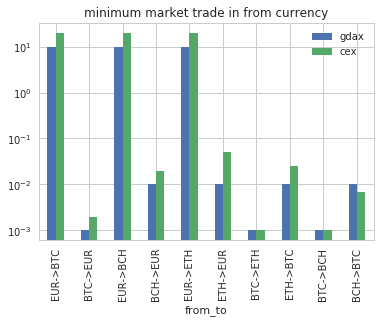

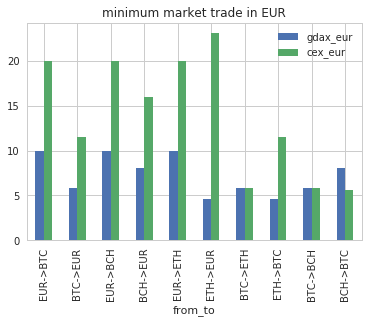

In [158]:
df.plot(kind='bar', x='from_to', y=['gdax', 'cex'], logy=True, title='minimum market trade in from currency')
df.plot(kind='bar', x='from_to', y=['gdax_eur', 'cex_eur'], title='minimum market trade in EUR')

# Observations

1. Sell trades depend on currency price.
2. Non-fiat trades generally have lower minimum size.
3. For creating offers on cex, we need to compare minimum sizes in the same bucket. E.g. if we create an offer on CEX to sell BTC the relevant minimum size is 'EUR->BTC' (as other people buy btc with our offer) and hence we close the circle in the same bucket, as we buy btc on GDAX.
  1. *For all pairs except 'BCH->BTC' the minimum size on CEX is generally larger than on GDAX.* This is independent of the current price, as both marketplaces denote minimum sizes in the same currencies.